In [46]:
import sys
#add directory to path to allow importing of modules if not already in path
if "/home/d.gaillard/source/NIPTov-analysis-tools" not in sys.path:
    sys.path.append("/home/d.gaillard/source/NIPTov-analysis-tools")


import WCR_analysis_tools
from importlib import reload
reload(WCR_analysis_tools)
from WCR_analysis_tools import *

In [47]:
# load CPA per case
import pandas as pd
from pathlib import Path
def get_CPA_from_wiseX(list_of_statfiles):
    """
    Function to extract CPA scores from statistics text files from WISECONDORX outputs
    """

    ids = [statfile.stem.split('_')[0] for statfile in list_of_statfiles]
    cpa_scores = []
    for statfile in list_of_statfiles:
        with open(statfile) as f:
            last_line = f.readlines()[-1]
            cpa_score = float(last_line.split(':')[-1].replace('\n', ''))
            cpa_scores.append(cpa_score)

    df = pd.DataFrame(
        {
            'PGDXID': ids,
            'cpa_score_PE': cpa_scores
        }).set_index('PGDXID')

    return df

base_path = Path('/home/d.gaillard/paired_ovarian/snakemake-wisecondorx-loocv/output_folder/outfiles')

list_of_statfiles = list(base_path.joinpath('benign').glob("*looref_statistics.txt"))
cpa_benign = get_CPA_from_wiseX(list_of_statfiles)


list_of_statfiles = list(base_path.joinpath('malignant').glob("*ref_benign_statistics.txt"))
cpa_malignant = get_CPA_from_wiseX(list_of_statfiles)

cpa_benign['label'] = 0
cpa_malignant['label'] = 1
cpa_df = pd.concat([cpa_malignant,cpa_benign]).reset_index()

# load HE4 and RMI
import numpy as np
dfclin = pd.read_spss("/home/d.gaillard/paired_ovarian/clinical_data/NIPT-clinical_he4_data.sav")
dfclin.rename(columns={'Barcode' : 'barcode'}, inplace=True)
dfclin.rename(columns={'Studienummer' : 'studienummer'}, inplace=True)

dfclin = dfclin.loc[:, ['studienummer','barcode','HE4', 'RMI']]
dfclin['log_HE4'] = np.log(dfclin['HE4'] + 1)
dfclin['log_RMI'] = np.log(dfclin['RMI'] + 1)
dfclin['studienummer'] = dfclin['studienummer'].astype('int').astype('str')

# labels df
labels = pd.read_csv('/home/d.gaillard/paired_ovarian/label_data/labels.csv', dtype="string")
labels.rename(columns={'Patient_ID_1' : 'studienummer'}, inplace=True)

# merge clin df, labels and paired-CPA
df = pd.merge(dfclin, labels, on='studienummer')
df = pd.merge(df, cpa_df, on='PGDXID')

# combine with SE results
SE_results = pd.read_csv('/home/d.gaillard/paired_ovarian/single_end_results/cpa_per_case_SE.csv')
SE_results.rename(columns={"cpa_score" : "cpa_score_SE"}, inplace=True)
df = pd.merge(df, SE_results, on='barcode', suffixes=['_df', '_SE'])
df = df.fillna(df.mean())
df['log_cpa_score_PE'] = np.log(df['cpa_score_PE'])
df['log_cpa_score_SE'] = np.log(df['cpa_score_SE'])


/tmp/ipykernel_2249827/3827701543.py:61: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean())


In [48]:
# get mean insert size per case
df_insertsize_statistics = pd.read_csv('/home/d.gaillard/paired_ovarian/fragment_lengh_distibution/summary_statistics/summary_statistics.csv')
# convert sample name to PGDXID
df_insertsize_statistics['PGDXID'] = df_insertsize_statistics['sample'].str.split('_').str[0]

# merge with df on PGDXID
df = pd.merge(df, df_insertsize_statistics, on='PGDXID')


In [49]:
import pathlib
import json
# first, get the labels
labels = {}
with open('/home/d.gaillard/paired_ovarian/label_data/labels.csv', 'r') as f:
    for line in f:
        # skip the header
        if line.startswith('PGDXID'):
            continue
        line = line.strip().split(',')
        labels[line[0]] = line[3]

# then, get the counts and labels for each case, filtering duplicates using bitwise NOT AND with 0x400
counts = {}
for json_file in pathlib.Path('/home/d.gaillard/paired_ovarian/fragment_lengh_distibution/nucleosome_distance/').glob('*.json'):
    with open(json_file, "r") as f:
        # load the dictionary from the file
        nuc_dict = json.load(f)
    counts[json_file.stem.split('_')[0]] = np.zeros(1201)
    for dist in nuc_dict.keys():
        counts[json_file.stem.split('_')[0]][int(dist)+600] = sum({key: value for key, value in nuc_dict[dist].items() if not int(key) & 0x400}.values())

# normalize the counts by dividing by the total number of reads
for case in counts.keys():
    counts[case] = counts[case]/sum(counts[case])

# calculate minimum
minima = {}
for case in counts.keys():
    minima[case] = np.min(counts[case][600-50:600+50])

# calculate maximum
maxima = {}
for case in counts.keys():
    maxima[case] = np.max(counts[case][600-500:600+500])


# calculate delta and store in maligant and benign numpy arrays and in a dictionary for saving to json
delta = {}
malignant_delta = []
benign_delta = []
for i, case in enumerate(minima.keys()):
    delta[case] = minima[case] - maxima[case]

df_delta = pd.DataFrame.from_dict(delta, orient='index', columns=['delta'])
df = df.merge(df_delta, left_on='PGDXID', right_index=True)

In [50]:
# load iwFAF data
iwfaf = pd.read_csv('/home/d.gaillard/paired_ovarian/fragment_lengh_distibution/iwfaf_table/iwfaf_dataframe.csv')
iwfaf.columns = ['PGDXID', 'iwFAF']

df = df.merge(iwfaf, on='PGDXID')

In [54]:
df.columns

Index(['studienummer', 'barcode', 'HE4', 'RMI', 'log_HE4', 'log_RMI', 'PGDXID',
       'Patient_ID_2', 'Lesion_Type', 'cpa_score_PE', 'label_df',
       'cpa_score_SE', 'label_SE', 'log_cpa_score_PE', 'log_cpa_score_SE',
       'sample', 'mean', 'median', 'mode', 'std_dev', 'delta', 'iwFAF'],
      dtype='object')

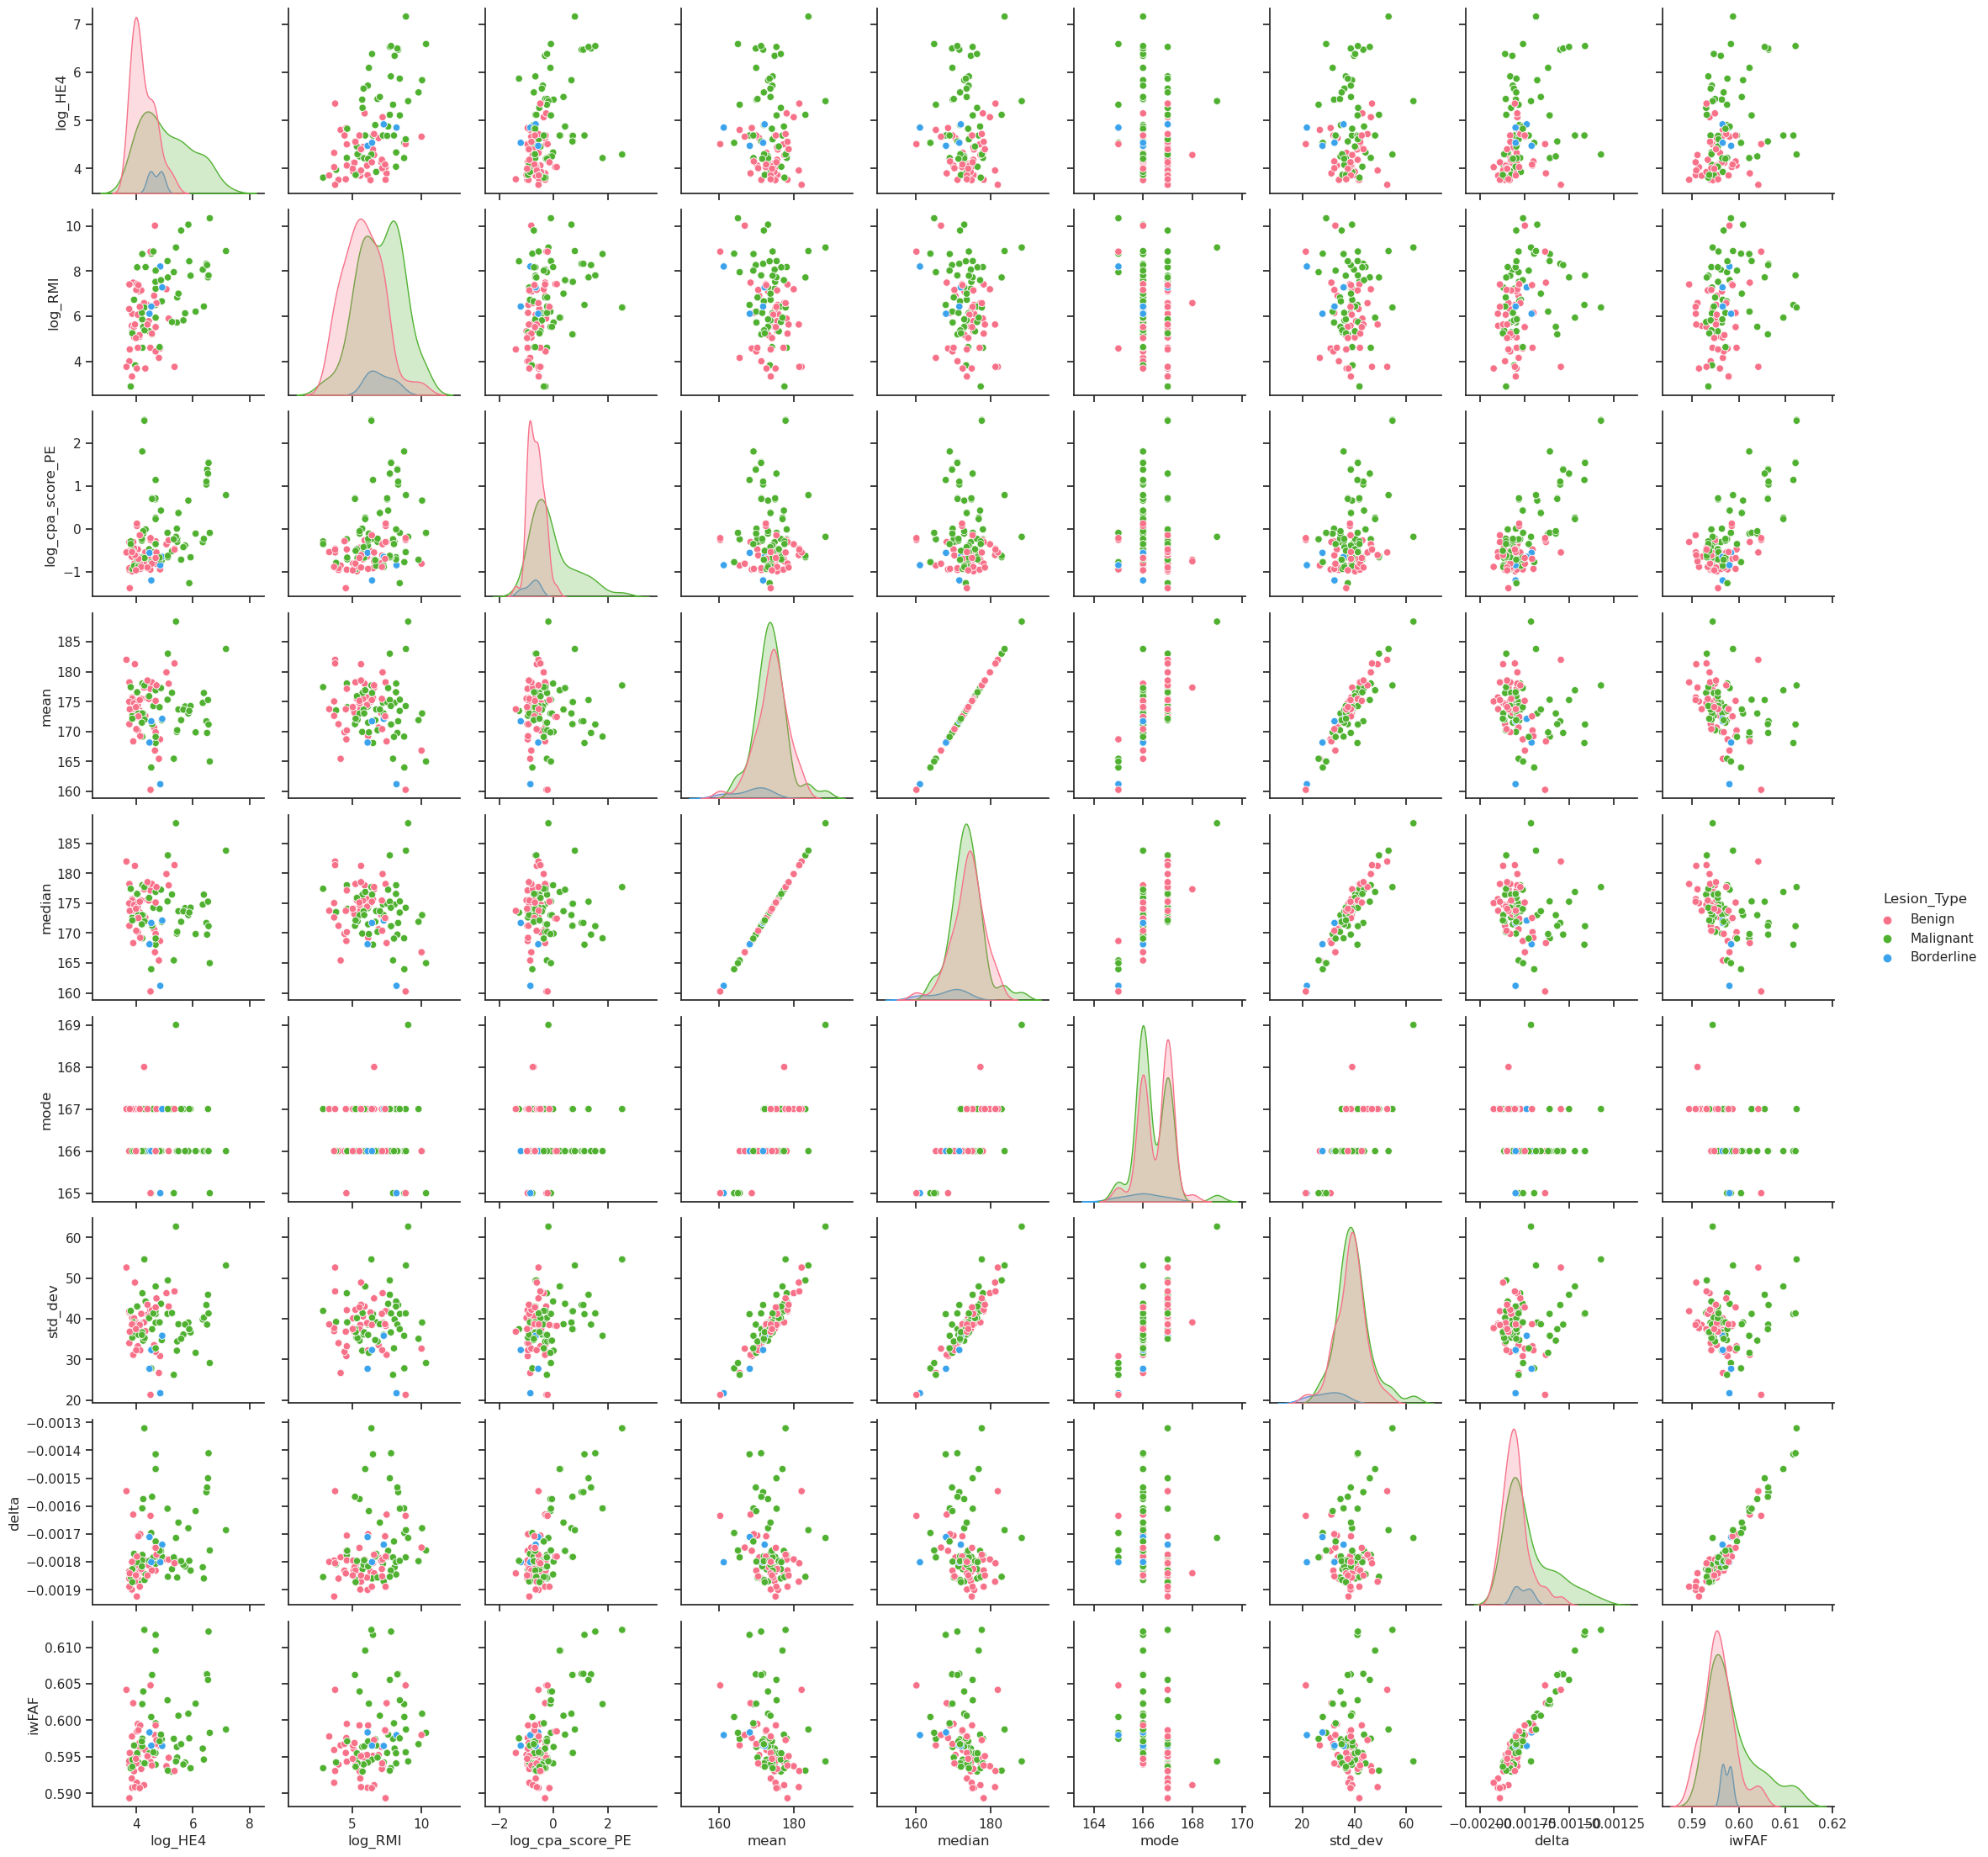

In [56]:
# generate a pairplot with seaborn of: HE4, RMI, CPA, mean insert size
import seaborn as sns
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df, vars=["log_HE4", "log_RMI", "log_cpa_score_PE", "mean", "median","mode", "std_dev", "delta", "iwFAF"], hue="Lesion_Type", palette="husl")
plt.show()